# Market Basket Analysis

<h3>📌 Project Summary: Market Basket Analysis Using Association Rules</h3>

<p>
This project aims to uncover purchasing patterns and product associations within a retail dataset using Market Basket Analysis. 
The objective is to identify item combinations that frequently occur together in customer transactions by applying the Apriori algorithm and generating association rules.
</p>

<p><strong>The process involves:</strong></p>
<ul>
  <li>Cleaning and preparing transactional data</li>
  <li>Structuring data into basket format</li>
  <li>Generating frequent itemsets using the Apriori algorithm</li>
  <li>Deriving association rules based on support, confidence, and lift</li>
  <li>Visualising strong product relationships to support business decision-making</li>
</ul>

<p>
Market Basket analysis is a foundation to plan strategies such as product bundling, cross-selling, and personalised recommendations.
</p>


### ✅ Importing the required libraries and modules
<p> FYI all the essential libraries for this project are at the top of the notebook for the clarity</p>

In [87]:
# Core Libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Market Basket Analysis
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Graph Visualization
import networkx as nx


### ✅ Loading the data from the local folder

In [88]:
data = pd.read_csv(r"C:\GitHub\MarketBasketAnalysis\Data\OnlineRetail.csv")

### ✅ Basic Exploratory Data Analysis (EDA)

In [9]:
print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None
  InvoiceNo StockCode                          Description  Quantity  \
0    541431     23166       MEDIUM CERAMIC TOP STORAGE JAR     74215   
1   C541433     23166       MEDIUM CERAMIC TOP STORAGE JAR    -74215   
2    549222     16008  SMALL FOLDING SCISSOR(POINTED EDGE)        24   
3    556201     17021               NAMASTE SWAGAT INCENSE        36   
4    549222     20665           

### ✅ Count missing values per column

In [23]:
missing_values = data.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


<h3>✅💡 Handling Credit Notes</h3>

<p>
Some transactions in the dataset are <strong>credit notes</strong> (Invoice numbers starting with <strong>"C"</strong>), which cancel or reverse previous purchases. 
To avoid misleading results in the Market Basket Analysis, I removed <strong>both the credit notes and the original invoices they cancel</strong>.
</p>

<p>
I also removed:
<ul>
  <li>Transactions with <strong>negative quantities</strong></li>
  <li>Rows with <strong>zero or missing prices</strong></li>
</ul>
</p>

<p>
This ensures the analysis includes only <strong>valid, completed purchases</strong>, giving accurate product association insights.
</p>


In [26]:
# Identifying credit notes
credit_notes = data[data['InvoiceNo'].astype(str).str.startswith('C')].copy()
credit_notes.loc[:, 'OriginalInvoiceNo'] = credit_notes['InvoiceNo'].str[1:]

# Identifying original invoices related to credit notes
original_invoice_nos = credit_notes['OriginalInvoiceNo'].unique().tolist()

# Identifying credit note InvoiceNos
credit_note_invoice_nos = credit_notes['InvoiceNo'].unique().tolist()

# Identifying possible invalid transactions (not starting with 'C') that have negative quantity or missing/zero price
problematic_regulars = data[
    (~data['InvoiceNo'].astype(str).str.startswith('C')) &
    (
        (data['Quantity'] < 0) |
        (data['UnitPrice'].isnull()) |
        (data['UnitPrice'] == 0)
    )
]
problematic_regular_invoice_nos = problematic_regulars['InvoiceNo'].unique().tolist()

# Combining all invalid invoices to remove
all_invalid_invoice_nos = set(original_invoice_nos + credit_note_invoice_nos + problematic_regular_invoice_nos)


### ✅ Now that we have identified the data irrelevant to our analysis we will keep only valid invoices

In [29]:
cleaned_data = data[~data['InvoiceNo'].isin(all_invalid_invoice_nos)]

### ✅ Cleaned data check

In [33]:
print("Cleaned dataset shape:", cleaned_data.shape)
print("Sample data:")
print(cleaned_data.head())

Cleaned dataset shape: (527384, 8)
Sample data:
  InvoiceNo StockCode                          Description  Quantity  \
0    541431     23166       MEDIUM CERAMIC TOP STORAGE JAR     74215   
2    549222     16008  SMALL FOLDING SCISSOR(POINTED EDGE)        24   
3    556201     17021               NAMASTE SWAGAT INCENSE        36   
4    549222     20665                 RED RETROSPOT PURSE          6   
5    542237     20719               WOODLAND CHARLOTTE BAG        10   

        InvoiceDate  UnitPrice  CustomerID         Country  
0  18/01/2011 10:01       1.04     12346.0  United Kingdom  
2   7/04/2011 10:43       0.25     12347.0         Iceland  
3   9/06/2011 13:01       0.30     12347.0         Iceland  
4   7/04/2011 10:43       2.95     12347.0         Iceland  
5  26/01/2011 14:30       0.85     12347.0         Iceland  


In [34]:
missing_values = cleaned_data.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     130057
Country             0
dtype: int64


<h3>✅💡 Handling Missing CustomerID Values</h3>

<p>
130,057 transactions are missing <strong>CustomerID</strong> values.
However, since the primary objective of this project is to perform <strong>Market Basket Analysis</strong>, which focuses on the associations between products purchased together in a single transaction, I will retain transactions with missing <strong>CustomerID</strong>.
</p>

<p>
These missing values do not affect the quality or accuracy of the analysis, as the insights rely solely on <strong>product co-occurrence within transactions</strong>, not on customer identity.
</p>


In [35]:
print(cleaned_data.describe())

            Quantity      UnitPrice     CustomerID
count  527384.000000  527384.000000  397327.000000
mean       10.553320       3.849848   15296.361949
std       155.917896      41.849482    1712.531474
min         1.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13969.000000
50%         3.000000       2.080000   15159.000000
75%        10.000000       4.130000   16800.000000
max     80995.000000   13541.330000   18287.000000


### 🔍 Unique products, invoices, customers, and countries

In [36]:
print("Unique Products:", cleaned_data['Description'].nunique())
print("Unique Invoices:", cleaned_data['InvoiceNo'].nunique())
print("Unique Customers:", cleaned_data['CustomerID'].nunique())
print("Countries:", cleaned_data['Country'].unique())

Unique Products: 4024
Unique Invoices: 19909
Unique Customers: 4334
Countries: ['United Kingdom' 'Iceland' 'Finland' 'Italy' 'Norway' 'Bahrain' 'Spain'
 'Portugal' 'Switzerland' 'Austria' 'Cyprus' 'Belgium' 'Unspecified'
 'Denmark' 'Australia' 'France' 'Germany' 'Greece' 'Sweden' 'Israel' 'USA'
 'Saudi Arabia' 'Poland' 'United Arab Emirates' 'Singapore' 'Japan'
 'Netherlands' 'Lebanon' 'Brazil' 'Czech Republic' 'EIRE'
 'Channel Islands' 'European Community' 'Lithuania' 'Canada' 'Malta'
 'Hong Kong']


### 📊 Most popular products by quantity sold

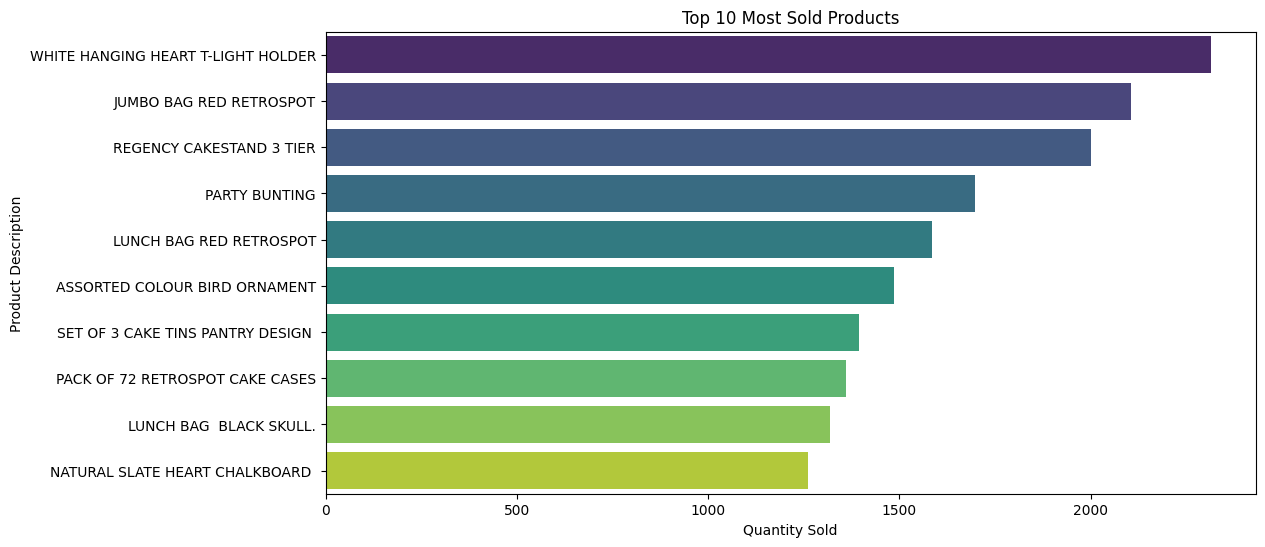

In [43]:
top_products = cleaned_data['Description'].value_counts().head(10)
plt.figure(figsize=(12,6))
sns.barplot(y=top_products.index, x=top_products.values, hue=top_products.index, palette='viridis', legend=False)
plt.title('Top 10 Most Sold Products')
plt.xlabel('Quantity Sold')
plt.ylabel('Product Description')
plt.show()

### 📊 Number of transaction by countries

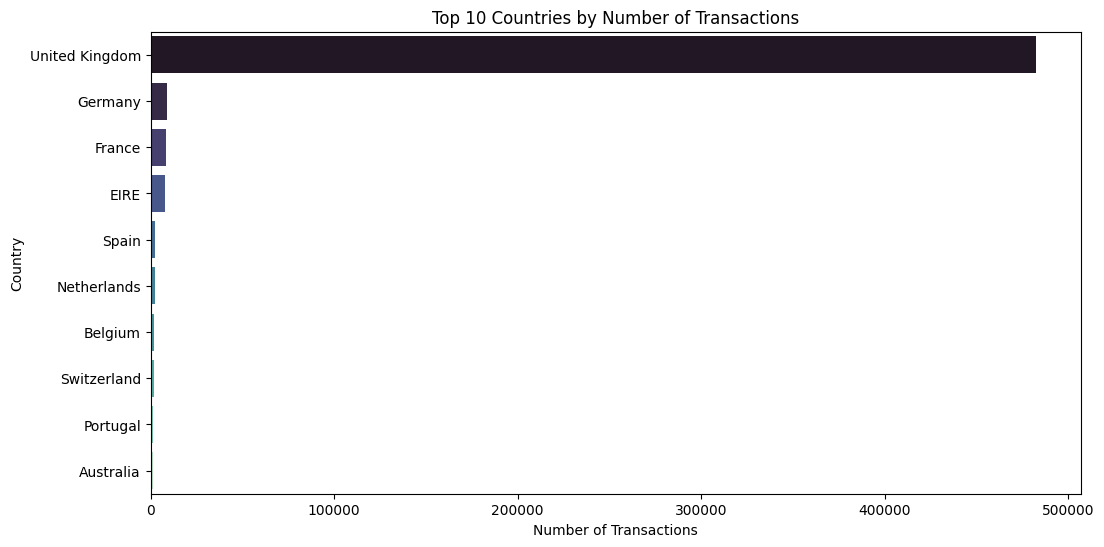

In [44]:
country_counts = cleaned_data['Country'].value_counts().head(10)

plt.figure(figsize=(12,6))
sns.barplot(y=country_counts.index, x=country_counts.values, hue=country_counts.index, palette='mako')
plt.title('Top 10 Countries by Number of Transactions')
plt.xlabel('Number of Transactions')
plt.ylabel('Country')
plt.show()

### 🧭 The United Kingdom accounts for the overwhelming majority of transactions, indicating a primarily domestic customer base.

<h2>✅ Prepare Transactions for Market Basket Analysis</h2>

<h3>🛠️ Transaction Encoding using TransactionEncoder</h3>

<p>
Now is the time to convert the list of item descriptions per transaction into a one-hot encoded format as required by Apriori.
</p>

<p>
This also requires the <code>mlxtend</code> library. If it is not already installed, this can be installed using the following command in your command prompt:
</p>

<pre><code>pip3 install mlxtend</code></pre>

<p> FYI all the essential libraries for this project are at the top of the notebook for the clarity</p>
<p>
This step converts each transaction into a list of items purchased together.
</p>


In [58]:
# Group products by InvoiceNo to create basket-like structure
transactions = cleaned_data.groupby('InvoiceNo')['Description'].apply(list)

# Convert to list of lists for encoding
transactions_list = transactions.tolist()

# Preview
print("Sample transaction:\n", transactions_list[0])
print(f"\nTotal transactions prepared: {len(transactions_list)}")


Sample transaction:
 ['GLASS STAR FROSTED T-LIGHT HOLDER', 'SET 7 BABUSHKA NESTING BOXES', 'WHITE METAL LANTERN', 'RED WOOLLY HOTTIE WHITE HEART.', 'KNITTED UNION FLAG HOT WATER BOTTLE', 'CREAM CUPID HEARTS COAT HANGER', 'WHITE HANGING HEART T-LIGHT HOLDER']

Total transactions prepared: 19909


<h3> ✅ Initialising the encoder and creating a one-hot encoded DataFrame </h3>

<p>This step transforms the list created in the earlier step into a format suitable for analysis by representing each product as TRUE or False in a wide table. </p>

In [59]:
te = TransactionEncoder()
te_ary = te.fit(transactions_list).transform(transactions_list)
transaction_df = pd.DataFrame(te_ary, columns=te.columns_)
transaction_df.head()

,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


<h3> 🛠️ Applying the Apriori Algorithm </h3>

<p> Here the Apriori algorithm is applieed to identify sets of products that were frequently purchased together in transactions, based on a minimum support threshold 2%. </p>

<p> FYI all the essential libraries for this project are at the top of the notebook for the clarity</p>

In [55]:
# Generate frequent itemsets
frequent_itemsets = apriori(transaction_df, min_support=0.02, use_colnames=True)

# Preview results
frequent_itemsets.sort_values(by='support', ascending=False).head(10)


,support,itemsets
275,0.112964,(WHITE HANGING HEART T-LIGHT HOLDER)
102,0.104676,(JUMBO BAG RED RETROSPOT)
198,0.099000,(REGENCY CAKESTAND 3 TIER)
157,0.084183,(PARTY BUNTING)
127,0.078156,(LUNCH BAG RED RETROSPOT)
15,0.072932,(ASSORTED COLOUR BIRD ORNAMENT)
219,0.069315,(SET OF 3 CAKE TINS PANTRY DESIGN )
149,0.065799,(PACK OF 72 RETROSPOT CAKE CASES)
120,0.063539,(LUNCH BAG BLACK SKULL.)
139,0.062585,(NATURAL SLATE HEART CHALKBOARD )


<h3> Generating Association Rules </h3>

<p>
Now using the frequest itemset, association rules can be created. </p>

<p> FYI all the essential libraries for this project are at the top of the notebook for the clarity</p>

In [56]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0) # Generate association rules from frequent itemsets

rules_sorted = rules.sort_values(by="lift", ascending=False) #sorting by the lift value
rules_sorted.head(10) #previewing the head

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
158,"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...",(PINK REGENCY TEACUP AND SAUCER),0.038375,0.038324,0.027123,0.706806,18.442734,1.0,0.025653,3.280001,0.983520,0.547112,0.695122,0.707269
159,(PINK REGENCY TEACUP AND SAUCER),"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...",0.038324,0.038375,0.027123,0.707733,18.442734,1.0,0.025653,3.290225,0.983469,0.547112,0.696069,0.707269
161,(GREEN REGENCY TEACUP AND SAUCER),"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",0.050731,0.029986,0.027123,0.534653,17.829842,1.0,0.025602,2.084497,0.994359,0.506092,0.520268,0.719588
156,"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",(GREEN REGENCY TEACUP AND SAUCER),0.029986,0.050731,0.027123,0.904523,17.829842,1.0,0.025602,9.942346,0.973094,0.506092,0.899420,0.719588
25,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.050731,0.038324,0.031694,0.624752,16.301700,1.0,0.029750,2.562777,0.988820,0.552539,0.609798,0.725876
24,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.038324,0.050731,0.031694,0.826999,16.301700,1.0,0.029750,5.487063,0.976064,0.552539,0.817753,0.725876
157,"(PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",(ROSES REGENCY TEACUP AND SAUCER ),0.031694,0.053343,0.027123,0.855784,16.043138,1.0,0.025433,6.564184,0.968359,0.468343,0.847658,0.682130
160,(ROSES REGENCY TEACUP AND SAUCER ),"(PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",0.053343,0.031694,0.027123,0.508475,16.043138,1.0,0.025433,1.970001,0.990504,0.468343,0.492386,0.682130
23,(GARDENERS KNEELING PAD CUP OF TEA ),(GARDENERS KNEELING PAD KEEP CALM ),0.038023,0.045758,0.027375,0.719947,15.733730,1.0,0.025635,3.407363,0.973456,0.485307,0.706518,0.659095
22,(GARDENERS KNEELING PAD KEEP CALM ),(GARDENERS KNEELING PAD CUP OF TEA ),0.045758,0.038023,0.027375,0.598244,15.733730,1.0,0.025635,2.394429,0.981347,0.485307,0.582364,0.659095


### Filter Strong Rules

#### To output the list of strong association rules just focusing on those with high confidence (>50%) and lift (>1.2) to ensure relevance and strength.

In [57]:
# Filter for high-confidence, high-lift rules
strong_rules = rules[(rules['lift'] > 1.2) & (rules['confidence'] > 0.5)]

# Preview top strong rules
strong_rules.sort_values(by='lift', ascending=False).head(10)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
159,(PINK REGENCY TEACUP AND SAUCER),"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...",0.038324,0.038375,0.027123,0.707733,18.442734,1.0,0.025653,3.290225,0.983469,0.547112,0.696069,0.707269
158,"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...",(PINK REGENCY TEACUP AND SAUCER),0.038375,0.038324,0.027123,0.706806,18.442734,1.0,0.025653,3.280001,0.983520,0.547112,0.695122,0.707269
161,(GREEN REGENCY TEACUP AND SAUCER),"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",0.050731,0.029986,0.027123,0.534653,17.829842,1.0,0.025602,2.084497,0.994359,0.506092,0.520268,0.719588
156,"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",(GREEN REGENCY TEACUP AND SAUCER),0.029986,0.050731,0.027123,0.904523,17.829842,1.0,0.025602,9.942346,0.973094,0.506092,0.899420,0.719588
25,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.050731,0.038324,0.031694,0.624752,16.301700,1.0,0.029750,2.562777,0.988820,0.552539,0.609798,0.725876
24,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.038324,0.050731,0.031694,0.826999,16.301700,1.0,0.029750,5.487063,0.976064,0.552539,0.817753,0.725876
157,"(PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",(ROSES REGENCY TEACUP AND SAUCER ),0.031694,0.053343,0.027123,0.855784,16.043138,1.0,0.025433,6.564184,0.968359,0.468343,0.847658,0.682130
160,(ROSES REGENCY TEACUP AND SAUCER ),"(PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",0.053343,0.031694,0.027123,0.508475,16.043138,1.0,0.025433,1.970001,0.990504,0.468343,0.492386,0.682130
23,(GARDENERS KNEELING PAD CUP OF TEA ),(GARDENERS KNEELING PAD KEEP CALM ),0.038023,0.045758,0.027375,0.719947,15.733730,1.0,0.025635,3.407363,0.973456,0.485307,0.706518,0.659095
22,(GARDENERS KNEELING PAD KEEP CALM ),(GARDENERS KNEELING PAD CUP OF TEA ),0.045758,0.038023,0.027375,0.598244,15.733730,1.0,0.025635,2.394429,0.981347,0.485307,0.582364,0.659095


### Creating a scatterplot of all the association rules

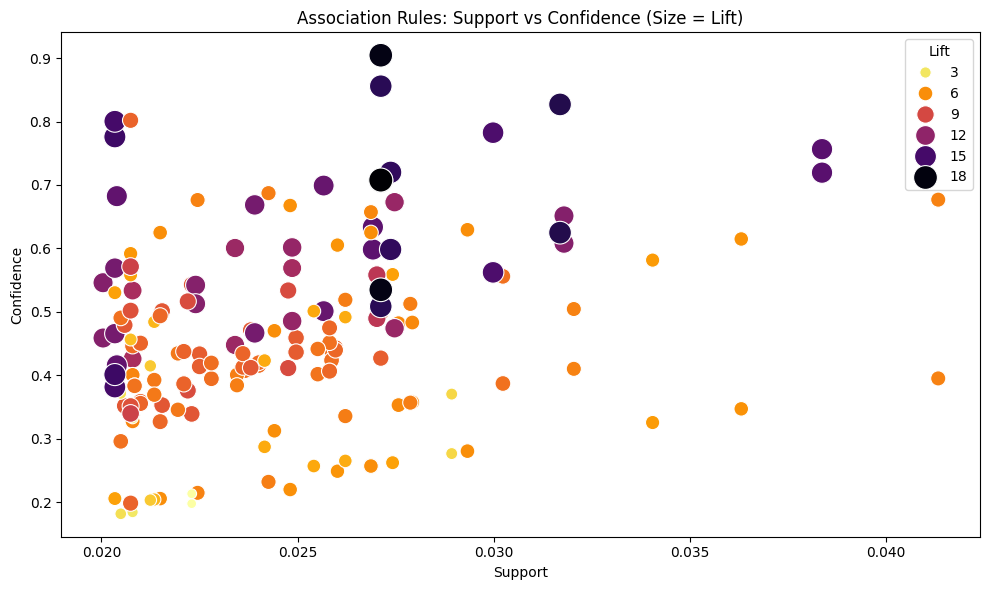

In [86]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=rules, x="support", y="confidence", size="lift", hue="lift", palette="inferno_r", sizes=(50, 300))
plt.title("Association Rules: Support vs Confidence (Size = Lift)")
plt.xlabel("Support")
plt.ylabel("Confidence")
plt.legend(title="Lift", loc='upper right')
plt.tight_layout()
plt.show()


<h3> 📊 Insights from the Output </h3>

<p> Higher lift values are concentrated toward the top — meaning the strongest rules also have high confidence. </p>

<p> Most rules have support between 2% and 3%, which is expected in transactional data with a wide product range. </p>

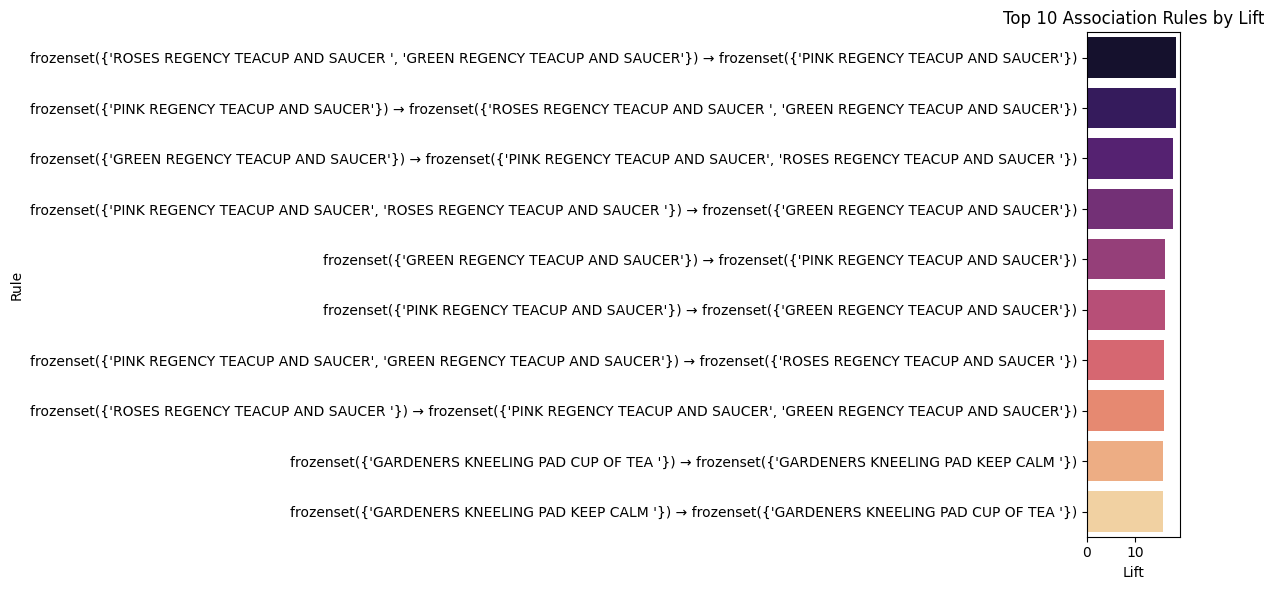

In [62]:
# Create a new column for the rule label
top10['rule'] = top10['antecedents'].astype(str) + " → " + top10['consequents'].astype(str)

# Plot with rule as hue and disable legend
plt.figure(figsize=(12,6))
sns.barplot(
    y="rule", 
    x="lift", 
    hue="rule", 
    data=top10, 
    palette="magma", 
    legend=False
)
plt.title("Top 10 Association Rules by Lift")
plt.xlabel("Lift")
plt.ylabel("Rule")
plt.tight_layout()
plt.show()


<h3>Visualisinge Association Rules as a Network Graph</h3>


<p>
Here we try to generate a network graph to visualise how items are connected via rules.
</p>

<p>
We are using networkx library and matplotlib, installation may be rquired for networkx
</p>
<pre><code>pip3 install networkx</code></pre>

<p> FYI all the essential libraries for this project are at the top of the notebook for the clarity</p>
<p>
Using a small sample for readabilty, top 50 by lift. 
</p>


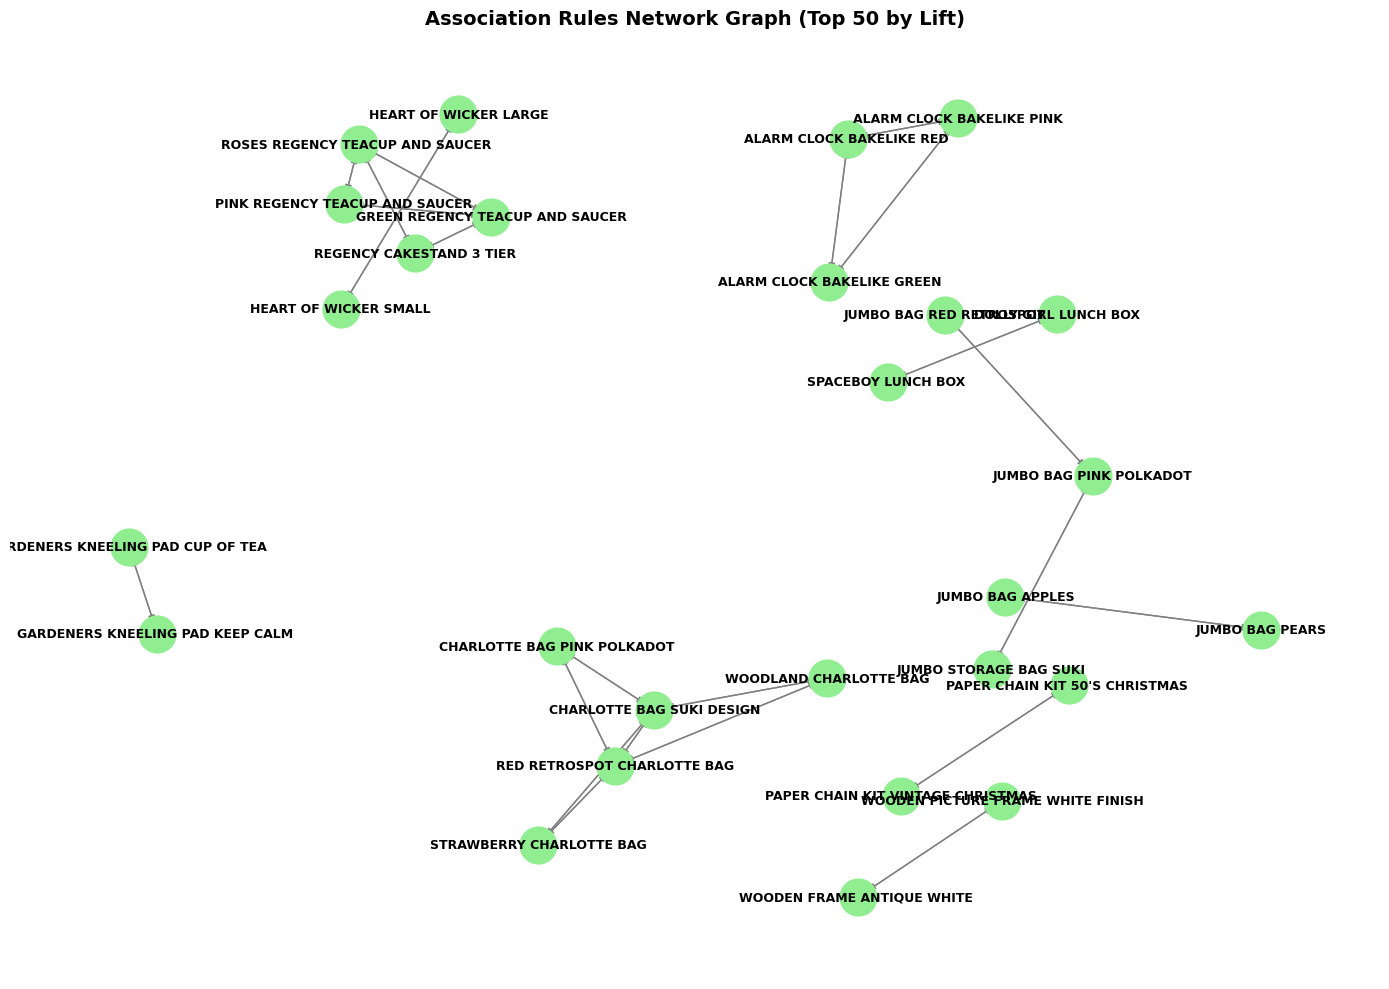

In [80]:
# creating a directed graph
G = nx.DiGraph()

# Just top 50 association rules being visualised sorted by by lift
sample_rules = rules.sort_values(by='lift', ascending=False).head(50)

# Adding edges between products with lift as weight
for _, row in sample_rules.iterrows():
    for antecedent in row['antecedents']:
        for consequent in row['consequents']:
            G.add_edge(antecedent, consequent, weight=row['lift'])

# Define layout
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=0.7, iterations=20)

# Nodes and edges
nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightgreen')
nx.draw_networkx_edges(G, pos, width=1, edge_color='gray', arrows=True)
nx.draw_networkx_labels(G, pos, font_size=9, font_weight='bold')

# Adding title and turning off the axes
plt.title("Association Rules Network Graph (Top 50 by Lift)", fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()


<h3>📌 Key Insights from Network Graph</h3>

<ul>
  <li><strong>🫖 Tea Set Cluster:</strong> <em>Regency teacups, saucers, and cakestands</em> are often bought together — ideal for <strong>gift set bundling</strong>.</li>
  
  <li><strong>⏰ Alarm Clocks:</strong> Color variants of <em>Bakeline alarm clocks</em> are linked — consider <strong>mix-and-match promotions</strong>.</li>
  
  <li><strong>🎒 Bags & Lunch Boxes:</strong> <em>Jumbo bags</em> and <em>lunch boxes</em> cluster — great for <strong>back-to-school or travel bundles</strong>.</li>
  
</ul>
